
# Lorenz 63 Model Code for Project \# 1

### Program to investigate concepts of tangent linear models, adjoint sensitivity, and singular vectors with the Lorenz 63 model
    

In [3]:
import numpy as np # NumPy for numerical computations
import matplotlib.pyplot as plt # Matplotlib for plotting

This is a program to investigate concepts of tangent linear models, adjoint sensitivity, and singular vectors with the Lorenz 63 model.
   - Aneesh Subramanian, September 2023

   - Ryan Torn, August 2020,
   - using matlab code originally developed by Greg Hakim

### Define the Lorenz 63 model equations

In [4]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    """
    Calculate the right-hand side of the Lorenz 63 model equations.

    Parameters:
    x, y, z : float
        The current state variables.
    s, r, b : float, optional
        The parameters for the Lorenz equations. Default values are s=10, r=28, b=2.667.

    Returns:
    dxdt, dydt, dzdt : float
        The rate of change of the state variables.
    """
    dxdt = s * (y - x)
    dydt = r * x - y - x * z
    dzdt = x * y - b * z
    return dxdt, dydt, dzdt

###  Compute the tangent linear model matrix for Lorenz 63 model by brute force based on input forecast trajectory

In [5]:
def lorenz_tlm(tvec, x, y, z, s=10, r=28, b=2.667):
    """
    Compute the tangent linear model (TLM) matrix for the Lorenz 63 system.
    Tangent linear model also sometimes called propogator matrix.

    This function calculates the TLM by integrating the linearized equations
    along a given trajectory.

    Parameters:
    tvec (array): Time vector for the trajectory
    x, y, z (arrays): State variables of the Lorenz system along the trajectory
    s, r, b (float): Lorenz system parameters (default: s=10, r=28, b=2.667)

    Returns:
    M (numpy.ndarray): The tangent linear model matrix

    The TLM is computed using the following steps:
    1. Initialize three basis vectors (v1, v2, v3)
    2. For each time step:
       a. Compute the instantaneous Jacobian matrix (tlm)
       b. Evolve each basis vector using the Jacobian
    3. Combine the final basis vectors to form the TLM matrix
    """
    # Initialize basis vectors
    v1 = np.array([1, 0, 0])
    v2 = np.array([0, 1, 0])
    v3 = np.array([0, 0, 1])

    for t in range(len(tvec) - 1):
        # Compute the instantaneous Jacobian matrix
        tlm = np.array([
            [-s,     s,      0],
            [(r - z[t]), -1., -x[t]],
            [y[t],   x[t],   -b]
        ])

        # Time step for this iteration
        dt = tvec[t + 1] - tvec[t]

        # Evolve each basis vector
        v1 = v1 + np.matmul(tlm, v1) * dt
        v2 = v2 + np.matmul(tlm, v2) * dt
        v3 = v3 + np.matmul(tlm, v3) * dt

    # Combine the evolved basis vectors to form the TLM matrix
    M = np.transpose([v1, v2, v3])

    return M

###  Compute the distance between two points in Lorenz 63 space based on Euclidean distance norm

In [6]:
def euclid_norm(x1, y1, z1, x2, y2, z2):
    print("x, y, z error: ", x2 - x1, y2 - y1, z2 - z1)

    err = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
    return err

### Define model parameters (timestep, number of steps, forecast length...)

In [7]:
dt = 0.002  # time step of the model (do not need to change)
num_steps = 20000  # Number of time steps for full model trajectory

step1 = 1000  # model time step to initiate forecast from
fcst_len = 1.0  # forecast length in model timesteps
tl_freq = 1  # frequency of model timesteps to use in computing tangent linear model
sing_val = 1  # singular value plot/compute
ic_error = np.array([0.1, 0.1, 0.1])  # initial condition error to add to forecast ## identical in all directions initially
xf_sens = np.array([0., 0., 1.])  # metric to compute sensitivity in x, y, z space (0, 0, 1) means compute sensitivity of z forecast

plot3d = True  # True to plot forecast in 3D space
plotxz = True  # True to plot in x-z plane
plot_nlfcst = False  # True to plt non-linear forecast
plot_sv = True  # True to plot singular vectors
sv_plot_freq = 20  # Frequency of time steps to plot singular vectors

fcst_steps = int(fcst_len / dt)

###  Create arrays needed for calculations.  Need one more for the initial values

In [8]:
xtraj = np.empty(num_steps + 1) # Full x trajectory
ytraj = np.empty(num_steps + 1) # Full y trajectory
ztraj = np.empty(num_steps + 1) # Full z trajectory

tfcst = np.empty(fcst_steps + 1) # Time array for forecast period
xfcst = np.empty(fcst_steps + 1) # x forecast with initial condition error
yfcst = np.empty(fcst_steps + 1) # y forecast with initial condition error
zfcst = np.empty(fcst_steps + 1) # z forecast with initial condition error

xtrue = np.empty(fcst_steps + 1) # x true forecast (without initial condition error)
ytrue = np.empty(fcst_steps + 1) # y true forecast (without initial condition error)
ztrue = np.empty(fcst_steps + 1) # z true forecast (without initial condition error)

# Arrays for tangent linear model trajectory (will be populated later)

ttlm = []
xtlm = []
ytlm = []
ztlm = []

### Set initial values for the full trajectory

In [9]:
xtraj[0], ytraj[0], ztraj[0] = (0., 1., 1.05)

Step through time, calculating the partial derivatives at the current point and using them to estimate the next point

In [10]:
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xtraj[i], ytraj[i], ztraj[i])
    xtraj[i + 1] = xtraj[i] + (x_dot * dt)
    ytraj[i + 1] = ytraj[i] + (y_dot * dt)
    ztraj[i + 1] = ztraj[i] + (z_dot * dt)

###  Now initiate forecast from specified time step, add initial condition error

In [11]:
tfcst[0] = 0.0
xtrue[0], ytrue[0], ztrue[0] = (xtraj[step1], ytraj[step1], ztraj[step1])
xfcst[0], yfcst[0], zfcst[0] = (xtrue[0] + ic_error[0], ytrue[0] + ic_error[1], ztrue[0] + ic_error[2])

###  Step the forecast and truth through time

In [12]:
ttlm = []
xtlm = []
ytlm = []
ztlm = []

for i in range(fcst_steps):

    tfcst[i + 1] = tfcst[i] + dt

    x_dot, y_dot, z_dot = lorenz(xfcst[i], yfcst[i], zfcst[i])
    xfcst[i + 1] = xfcst[i] + (x_dot * dt)
    yfcst[i + 1] = yfcst[i] + (y_dot * dt)
    zfcst[i + 1] = zfcst[i] + (z_dot * dt)

    x_dot, y_dot, z_dot = lorenz(xtrue[i], ytrue[i], ztrue[i])
    xtrue[i + 1] = xtrue[i] + (x_dot * dt)
    ytrue[i + 1] = ytrue[i] + (y_dot * dt)
    ztrue[i + 1] = ztrue[i] + (z_dot * dt)

    #  Add this forecast time to tangent linear trajectory, if needed
    if (i % tl_freq == 0): # will add every time step for tl_freq = 0
        ttlm.append(tfcst[i])
        xtlm.append(xtrue[i])
        ytlm.append(ytrue[i])
        ztlm.append(ztrue[i])

        

In [13]:
print(xtlm[0:10], "....", xtlm[-10:])
xtest = xtraj[step1:step1+fcst_steps]
print(xtest[0:10], "....", xtest[-10:])

print("LENGTH: ", len(ttlm), len(xtest))

[-8.079695170651462, -8.086349569838188, -8.093165220354221, -8.100139798724387, -8.107270921888903, -8.114556147563762, -8.121992974612501, -8.129578843430012, -8.13731113633905, -8.145187178000105] .... [-8.653695114084318, -8.640822560734685, -8.627878991165337, -8.614870242297615, -8.601802163480833, -8.588680613211945, -8.575511455886994, -8.56230055858707, -8.549053787901338, -8.535777006789665]
[-8.07969517 -8.08634957 -8.09316522 -8.1001398  -8.10727092 -8.11455615
 -8.12199297 -8.12957884 -8.13731114 -8.14518718] .... [-8.65369511 -8.64082256 -8.62787899 -8.61487024 -8.60180216 -8.58868061
 -8.57551146 -8.56230056 -8.54905379 -8.53577701]
LENGTH:  500 500


###  Compute tangent linear model and estimated forecast error

In [14]:
M = lorenz_tlm(ttlm, xtlm, ytlm, ztlm)
tl_xf = np.matmul(M, ic_error)

print("tangent linear estimated error: ", euclid_norm(tl_xf[0], tl_xf[1], tl_xf[2], 0., 0., 0.))
print("actual Non-linear model error: ", euclid_norm(xfcst[-1], yfcst[-1], zfcst[-1], xtrue[-1], ytrue[-1], ztrue[-1]))

#  Compute initial condition sensitivity from adjoint of tangent linear model
xi_sens = np.matmul(np.transpose(M), xf_sens)

#  add initial condition error to truth consistent with sensitivity, but same size as ic_error
xi_sens[:] = xi_sens[:] / np.sqrt(np.sum(xi_sens[:] ** 2)) * np.sqrt(np.sum(ic_error[:] ** 2))

xsens = np.empty(fcst_steps + 1)
ysens = np.empty(fcst_steps + 1)
zsens = np.empty(fcst_steps + 1)
xsens[0], ysens[0], zsens[0] = (xtrue[0] + xi_sens[0], ytrue[0] + xi_sens[1], ztrue[0] + xi_sens[2])

#  Step the sensitivity IC error forecast forward in time, compute error
for i in range(fcst_steps):
    x_dot, y_dot, z_dot = lorenz(xsens[i], ysens[i], zsens[i])
    xsens[i + 1] = xsens[i] + (x_dot * dt)
    ysens[i + 1] = ysens[i] + (y_dot * dt)
    zsens[i + 1] = zsens[i] + (z_dot * dt)

print("Error from forecast with sensitivity initial condition error: ",
      euclid_norm(xsens[-1], ysens[-1], zsens[-1], xtrue[-1], ytrue[-1], ztrue[-1]))

x, y, z error:  0.11648942538284426 0.1571295151725195 -0.08661675100867643
tangent linear estimated error:  0.21392038780741615
x, y, z error:  0.11682624268418174 0.15680152346669463 -0.08828333209996231
actual Non-linear model error:  0.21454378450062808
x, y, z error:  0.10133397875501338 0.03140522363315945 -0.20555588153571946
Error from forecast with sensitivity initial condition error:  0.23131814402613773


###  Compute singular value decomposition of tangent linear model

In [15]:
u, s, vt = np.linalg.svd(M, full_matrices=True)

print("Singular Value: ", s[sing_val - 1])

Singular Value:  1.4849703940755714


###  Add initial-time singular vector to forecast

In [16]:
ic_sing = np.array(vt[sing_val - 1, :])
ic_sing[:] = ic_sing[:] / np.sqrt(np.sum(ic_sing[:] ** 2)) * np.sqrt(np.sum(ic_error[:] ** 2))

xsing = np.empty(fcst_steps + 1)
ysing = np.empty(fcst_steps + 1)
zsing = np.empty(fcst_steps + 1)
xsing[0], ysing[0], zsing[0] = (xtrue[0] + ic_sing[0], ytrue[0] + ic_sing[1], ztrue[0] + ic_sing[2])

###  Step forecast with singular vector IC error forward in time, compute error

In [17]:
for i in range(fcst_steps):
    x_dot, y_dot, z_dot = lorenz(xsing[i], ysing[i], zsing[i])
    xsing[i + 1] = xsing[i] + (x_dot * dt)
    ysing[i + 1] = ysing[i] + (y_dot * dt)
    zsing[i + 1] = zsing[i] + (z_dot * dt)

print("Error from forecast with SV initial condition error: ",
      euclid_norm(xsing[-1], ysing[-1], zsing[-1], xtrue[-1], ytrue[-1], ztrue[-1]))

x, y, z error:  0.14047047732991835 0.14189110868375288 -0.1639058509980238
Error from forecast with SV initial condition error:  0.2583218336033291


## Make 2D and 3D plots of the model trajectory

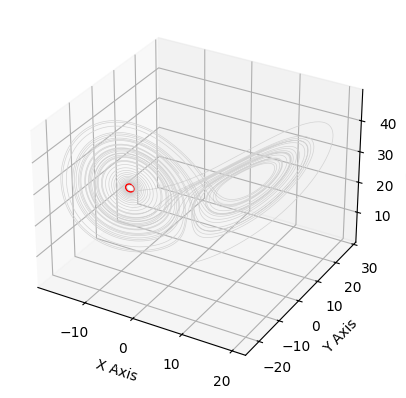

In [18]:
if plot3d:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  # Updated line

    ax.plot(xtraj, ytraj, ztraj, lw=0.5, color='lightgray')
    ax.plot(xtrue, ytrue, ztrue, lw=0.5, color='red')
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")

    plt.savefig('lorenz_xyz.png', format='png', dpi=150, bbox_inches='tight')
    plt.show()

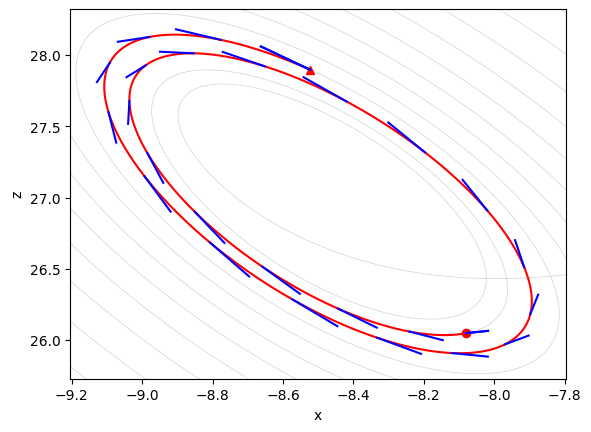

In [19]:
if (plotxz):

    fig = plt.figure()
    ax = fig.gca()
    ax.plot(xtraj, ztraj, lw=0.5, color='lightgray')
    ax.plot(xtrue, ztrue, '-', color='red')
    ax.plot(xtrue[0], ztrue[0], 'o', color='red')
    ax.plot(xtrue[-1], ztrue[-1], '^', color='red')

    if (plot_nlfcst):
        ax.plot(xfcst, zfcst, '-', color='green')
        ax.plot(xfcst[0], zfcst[0], 'o', color='green')
        ax.plot(xfcst[-1], zfcst[-1], '^', color='green')

    xmin = np.min([np.min(xtrue), np.min(xfcst)])
    xmax = np.max([np.max(xtrue), np.max(xfcst)])
    zmin = np.min([np.min(ztrue), np.min(zfcst)])
    zmax = np.max([np.max(ztrue), np.max(zfcst)])

    if (plot_sv):
        ax.plot([xtrue[0], xsing[0]], [ztrue[0], zsing[0]], '-', color='blue')
        ax.plot([xtrue[-1], xsing[-1]], [ztrue[-1], zsing[-1]], '-', color='blue')
        for i in range(0, len(xsing), sv_plot_freq):
            ax.plot([xtrue[i], xsing[i]], [ztrue[i], zsing[i]], '-', color='blue')

    plt.axis([xmin - (xmax - xmin) * 0.08, xmax + (xmax - xmin) * 0.08, zmin - (zmax - zmin) * 0.08,
              zmax + (zmax - zmin) * 0.08])
    plt.xlabel('x')
    plt.ylabel('z')

    plt.savefig('lorenz_xz.png', format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [20]:
arr = np.array([1,2,3,4])
arr[2]

3

# Project 1 Questions #
## Question 1 ##


In [21]:
dt = 0.002  # time step of the model (do not need to change)
num_steps = 20000  # Number of time steps for full model trajectory

step1 = 1000  # model time step to initiate forecast from
fcst_len = 1.0  # forecast length in model timesteps
tl_freq = 1  # frequency of model timesteps to use in computing tangent linear model
sing_val = 1  # singular value plot/compute
ic_error = np.array([0.1, 0.1, 0.1])  # initial condition error to add to forecast ## identical in all directions initially
xf_sens = np.array([0., 0., 1.])  # metric to compute sensitivity in x, y, z space (0, 0, 1) means compute sensitivity of z forecast

plot3d = True  # True to plot forecast in 3D space
plotxz = True  # True to plot in x-z plane
plot_nlfcst = False  # True to plt non-linear forecast
plot_sv = True  # True to plot singular vectors
sv_plot_freq = 20  # Frequency of time steps to plot singular vectors

fcst_steps = int(fcst_len / dt)

time_tlm = np.arange(0, fcst_steps*dt, dt)
print(len(time_tlm))

500


In [22]:
%%capture cap --no-stderr
## Changing the window starting point 
init_steps = np.arange(0,20000,fcst_steps) # starting step for each iteration


## Functions do not currently allow for modification of tl_freq, they will eventually!
def find_xyz_truth(xtraj, ytraj, ztraj, init_step, fcst_steps):
    xtrue = xtraj[init_step:init_step+fcst_steps+1]
    ytrue = ytraj[init_step:init_step+fcst_steps+1]
    ztrue = ztraj[init_step:init_step+fcst_steps+1]
    return(xtrue, ytrue, ztrue)

def find_xyz_fcst(xtraj, ytraj, ztraj, init_step, fcst_steps, ic_error):
    xfcst = np.empty(fcst_steps + 1) # x forecast with initial condition error
    yfcst = np.empty(fcst_steps + 1) # y forecast with initial condition error
    zfcst = np.empty(fcst_steps + 1) # z forecast with initial condition error

    xfcst[0] = xtraj[init_step] + ic_error[0]
    yfcst[0] = ytraj[init_step] + ic_error[1]
    zfcst[0] = ztraj[init_step] + ic_error[2]
    
    for i in range(fcst_steps):
        x_dot, y_dot, z_dot = lorenz(xfcst[i], yfcst[i], zfcst[i])
        xfcst[i + 1] = xfcst[i] + (x_dot * dt)
        yfcst[i + 1] = yfcst[i] + (y_dot * dt)
        zfcst[i + 1] = zfcst[i] + (z_dot * dt)
    
    return (xfcst, yfcst, zfcst)
  
time_tlm = np.arange(0, fcst_steps*dt, dt) 
error_compilation = [] ## will store all of the necessary info for each run as a tuple
## e.g. (initial_step, propogator_matrix, tlm_error_euclidian, nonlin_model_error)

for step in init_steps:
    xtrue,ytrue,ztrue = find_xyz_truth(xtraj,ytraj,ztraj,step,fcst_steps)
    xfcst,yfcst,zfcst = find_xyz_fcst(xtraj,ytraj,ztraj,step,fcst_steps,ic_error)

    ## Propogator Matrix and Projected xyz error
    M = lorenz_tlm(time_tlm, xtrue[:-1], ytrue[:-1], ztrue[:-1])
    tlm_error_xyz = np.matmul(M, ic_error) # propogating initial condition error forward
    
    ## Euclidian Error Calculations (total distance from true trajectory)
    tlm_error = euclid_norm(tlm_error_xyz[0], tlm_error_xyz[1], tlm_error_xyz[2], 0.0, 0.0, 0.0)
    fcst_error = euclid_norm(xfcst[-1], yfcst[-1], zfcst[-1], xtrue[-1], ytrue[-1], ztrue[-1])

    ## Final list of stuff to add to record
    ## Form of [initial_step, propogator_matrix, tlm_error_euclidian, nonlin_model_error]
    step_results = [step, M, tlm_error, fcst_error]
    error_compilation.append(step_results)

In [29]:

print(error_compilation)

[15000, array([[-1.2971425 , -0.63147286, -1.88569443],
       [-2.13473999, -1.44511577, -2.36609462],
       [-0.90269538, -0.12153637, -1.88972132]]), 0.7641623358552677, 0.7381901090573385]


x, y, z error:  0.11648942538284426 0.1571295151725195 -0.08661675100867643
tangent linear estimated error:  0.21392038780741615
x, y, z error:  0.11682624268418174 0.15680152346669463 -0.08828333209996231
actual Non-linear model error:  0.21454378450062808
x, y, z error:  0.10133397875501338 0.03140522363315945 -0.20555588153571946
Error from forecast with sensitivity initial condition error:  0.23131814402613773

In [73]:
xtrue,ytrue,ztrue = find_xyz_truth(xtraj,ytraj,ztraj,1000,fcst_steps)